# ML - Analiza Skupień

## 1. Przygotować zbiór danych do pracy

Naszym zbiorem danych, dla którego wykonamy zadanie będzie zbiór obrazków o wymiarach 8x8 przedstawiających cyfry.

In [1]:
from sklearn import datasets

digits = datasets.load_digits()
digits_data = digits.data
digits_target = digits.target

digits_data.shape

(1797, 64)

In [2]:
import matplotlib.pyplot as plt

# funkcja sluzy do wyswietlania obrazkow
# x i y to ilość obrazków w poziomie i w pionie
def printImgs(data, x, y):
    ig, ax = plt.subplots(y, x, figsize=(8, 3))
    imgs = data.reshape(x*y, 8, 8)
    for axi, img in zip(ax.flat, imgs):
        axi.set(xticks=[], yticks=[])
        axi.imshow(img, cmap=plt.cm.binary)

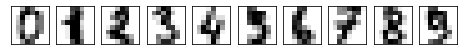

In [3]:
printImgs(digits_data[:10], 10, 1)

## 2. Popularne algorymty w analizie skupień

Uczenie nienadzorowane – to rodzaj uczenia maszynowego, którego zadaniem jest odkrywaniem w zbiorze danych wzorców bez wcześniej istniejących etykiet i przy minimalnej ingerencji człowieka. Uczenie nienadzorowane zakłada brak obecności oczekiwanego wyjścia w danych uczących.

Dwie główne metody stosowane w uczeniu nienadzorowanym to analiza składowych głównych oraz **analiza skupień**. Analiza skupień jest wykorzystywana w celu grupowania lub segmentowania zestawów danych ze wspólnymi atrybutami w celu ekstrapolacji występujących w nich zależności. Analiza skupień identyfikuje podobieństwa w danych i pozwala na grupowanie danych, które nie zostały oznaczone, sklasyfikowane ani skategoryzowane. Ponieważ analiza skupień bazuje na obecności lub braku takich podobieństw w nowej danych, może być wykorzystana aby wykryć nietypowe dane, które nie pasują do żadnej grupy. 

Jest to przegląd trzech najbardziej popularnych metod grupowania i charakterystyka, do jakich rodzajów sytuacji każda z nich nadaje się najlepiej.

### K-Means Clustering - wyjasnienie

Algorytm K-Means szuka z góry **określonej liczby klastrów** w nieoznaczonym wielowymiarowym zestawie danych. Osiąga to poprzez prostą koncepcję tego, jak wygląda optymalne grupowanie. "Centrum klastra” jest średnią arytmetyczną wszystkich punktów należących do klastra. Każdy punkt jest bliżej własnego centrum klastrów niż innych centrów klastrów. Wygenerujmy prosty zbiór danych:

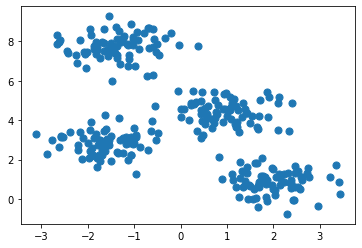

In [4]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

Na oko stosunkowo łatwo można wyróżnić cztery klastry. Algorytm K-Means robi to automatycznie:

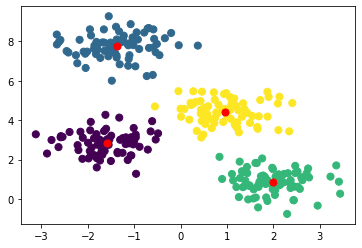

In [5]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4)
predicted_labels = km.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, s=50, cmap='viridis')
centroids = km.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=50)

Proste prawda!. Jak to działa?

W skrócie, podejście to wykorzystuje algorytm: oczekiwanie i maksymalizacja (E-M):

1. Zgadnij niektóre centra klastrowe
* Powtarzaj poniższe kroki, aż punkty zbiegną się:
    * krok E: przypisz punkty do najbliższego centrum klastra
    * krok M: ustaw centra skupienia na ich średnią
    

Krok E (krok oczekiwania) - obejmuje aktualizację naszych oczekiwań, do którego klastra należy każdy punkt

Krok M (krok maksymalizacji) jest tak nazywany, ponieważ wiąże się z maksymalizacją pewnej funkcji sprawności, która określa lokalizację centrów klastrów - w tym przypadku maksymalizacji dokonuje się, przyjmując prosty środek danych w każdym klastrze.

### Dla osób, którym ten tekst nie pomógł

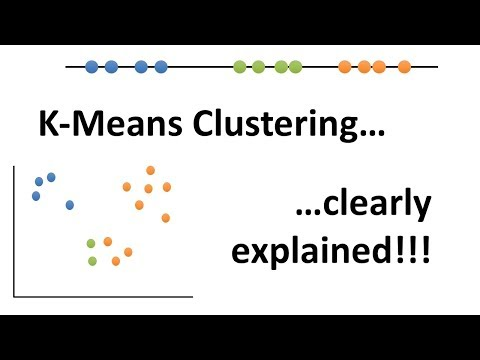

In [6]:
from IPython.display import YouTubeVideo
YouTubeVideo('4b5d3muPQmA', width=600, height=00)

### K-Means Clustering - przykład

Jednym z interesujących zastosowań klastrowania jest kompresja kolorów w obrazach. Na przykład wyobraź sobie, że masz obraz w milionach kolorów. Na większości obrazów duża liczba kolorów nie będzie używana, a wiele pikseli na obrazie będzie miało podobne lub nawet identyczne kolory.

Na przykład rozważmy obraz pokazany na poniższym rysunku, który pochodzi z modułu zestawów danych Scikit-Learn 

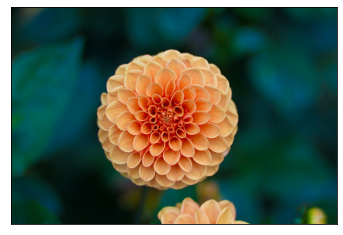

In [7]:
from sklearn.datasets import load_sample_image

flower = load_sample_image("flower.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(flower);

In [8]:
flower.shape

(427, 640, 3)

Sam obraz jest przechowywany w trójwymiarowej tablicy rozmiarów (wysokość, szerokość, RGB), zawierającej udziały czerwony / niebieski / zielony jako liczby całkowite od 0 do 255.

Przekształcimy dane do i przeskalujemy kolory tak, aby zawierały się między 0 a 1:

In [9]:
data = flower / 255.0 
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Teraz zmniejszmy te kolorory do zaledwie 16 kolorów, używając K-Means grupowania w przestrzeni pikseli. Ponieważ mamy do czynienia z bardzo dużym zestawem danych, użyjemy mini-partii k-średnich.

In [10]:
from sklearn.cluster import MiniBatchKMeans
km = MiniBatchKMeans(16)
labels = km.fit_predict(data)
new_colors = km.cluster_centers_[labels]

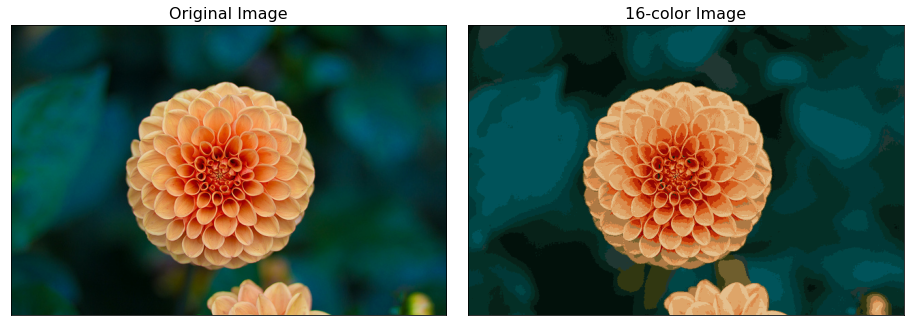

In [11]:
flower_recolored = new_colors.reshape(flower.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(flower)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(flower_recolored)
ax[1].set_title('16-color Image', size=16);

Rezultatem jest ponowne zabarwienie oryginalnych pikseli, przy czym każdemu pikselowi przypisany jest kolor jego najbliższego centrum skupienia.

### Paritioning Around Medoids - wyjaśnienie

PAM jest realizacją metody k-medoidowej, czyli takiej techniki grupowania, która dzieli zbiór danych zawierających n obiektów na k grup (skupień, ang. cluster) znanych a priori.

Działanie tego algorytmu zbliżone jest do działania algorytmu centroidów, z tą różnicą, że centroidy zostają tu zastąpione przez **medoidy**, czyli najbardziej centralne obiekty ze zbioru danych reprezentujące daną grupę, dla których **odległość od wszystkich pozostałych elementów wewnątrz danej grupy jest minimalna**. W skrócie - centrum naszego klastra musi być jakiś obiekt ze z bioru danych. Algorytm ten dąży do minimalizacji sumy odległości wszystkich elementów niebędących medoidami od najbliższych im medoidów.

Zaletą tego algorytmu jest jego odporność na obserwacje odstające (ang. outliers) oraz szumy występujące w danych (ang. robustness). Główną wadą algorytmu PAM jest brak możliwości zastosowania tej metody dla dużych zbiorów danych.

#### Algorytm PAM w postaci pseudokodu:

1. **Inicjalizacja** - Wybierz losowo k próbek i oznacz je jako medoidy
* **Przypisanie** - Pozostałym próbkom przypisz najbliższą medoidę, czyli próbkę wybraną w punkcie 1, względem której odległość Manhattan jest najniższa.

* **Korketa** - Iterując po wszystkich próbkach w klastrze, zmień jej status na medoidę oraz przelicz na nowo koszt konfiguracji (suma odległości innych punktów z klastra względem niej). Pod konieć tego kroku na medoidę wybierz tą próbkę, dla której koszt konfiguracji był najniższy i usuń wszystkie skojarzenia. Iteruj pomiędzy krokiem 2 a 3, póki koszt konfiguracji będzie malec.



### Paritioning Around Medoids - przykład

Algorytm PAM zostanie zaprezentowany na zbiorze Irysów. Liczba wymiarów tego zbioru przekracza 3, więc w celach prezenrachi zredukujemy liczbę wymiarów.

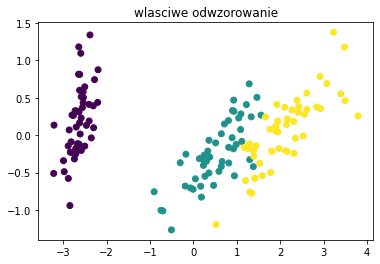

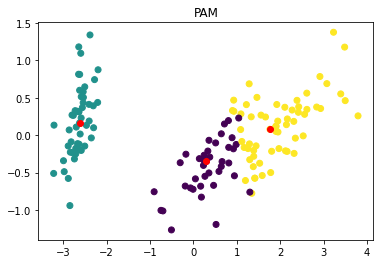

In [12]:
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

#pobranie danych i redukcja wymiarów
iris = datasets.load_iris()
data = iris.data
target = iris.target

#jedne z dostępnych metryk ["euclidean", "cosine"]
km = KMedoids(n_clusters = 3, metric="manhattan")
predicted_target = km.fit_predict(data)

#pobranie medoids i transformacja do 2D
data_2d = PCA(n_components=2).fit_transform(data)
medoids = km.cluster_centers_
medoids_index = np.array([np.where((data == i).all(axis=1))[0] for i in medoids]).flatten()
medoids_2d = np.array([data_2d[i] for i in medoids_index])

#klasyfikacja danych wejściowch
plt.figure(1)
plt.title("wlasciwe odwzorowanie")
plt.scatter(data_2d[:,0], data_2d[:,1], c=target, cmap='viridis')
#klasyfikacja danych wejściowch przez algorytm PAM
plt.figure(2)
plt.title("PAM")
plt.scatter(data_2d[:,0], data_2d[:,1], c=predicted_target, cmap='viridis')
plt.scatter(medoids_2d[:,0], medoids_2d[:,1], c="red")

Text(0.5, 0.92, 'PAM w 3D')

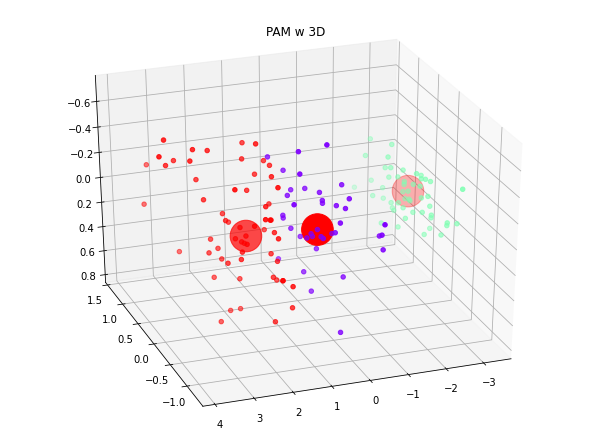

In [13]:
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

#pobranie danych i redukcja wymiarów do 3
data_3d = PCA(n_components=3).fit_transform(data) 
medoids_3d = np.array([data_3d[i] for i in medoids_index])

#plotowanie
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c=predicted_target, cmap='rainbow')
ax.scatter(medoids_3d[:, 0], medoids_3d[:, 1], medoids_3d[:, 2], s=1000, c='red')
ax.set_title("PAM w 3D")

### Hierarchical Clustering - wyjaśnienie

Istnieją dwa rodzaje klastrowania hierarchicznego: podziałowe i **aglomeracyjne**. W aglomeracyjnym korzystamy z podejścia "bottom-up", czyli zaczynamy od wielu klastrów składających się z jednego elementu i łączymy klastry aż otrzymamy jeden wielki klaster

**Algorytm wygląda następująco:**

1. Na początku traktuj każdy punkt jako jeden klaster. W ten sposób liczba klastrów na początku wynosi K, gdzie K to liczba punktów
2. Stwórz klaster przez połączenie dwóch najbliżyszch klastrów, w ten sposób zmniejszamy liczbę klastrów do K-1
3. Stwórz klaster przez połączenie dwóch najbliżyszch klastrów, w ten sposób zmniejszamy liczbę klastrów do K-2
4. Powtarzaj, aż otrzymasz 1 wielki klaster
5. Gdy stworzysz wielki klaster użyjemy dendrogramu do podziału klastru na wiele klastrów w zależności od problemu

Później wytłumaczymy czym jest dendrogram

**Jak liczymy dystans?**

Po pierwsze do liczenia dystansu możemy użyć różnych metryk. Może to być metryka Euklidesowa, ale może to też być metryka Manhattan

Po drugie możemy przyjąć kilka sposobów na liczenie dystansu między klastrami dla ustalonej metryki:
1. Odległość między najbliższymi punktami w klastrach (Single linkage)
2. Odległość między najdalszymi punktami w klastrach (Maximum or complete linkage)
3. Odległość między centroidami klastrów (Ward)
4. Średnia ze wszystkich odległości między punktami w klastrze (Average linkage)

![title](img/linkage_comp.png)

Jak widać odpowiedni dobór sposobu liczenia dystansu ma spory wpływ na wynik podziału na klastry. Problemem aglomeracyjnego klastrowania hierarhicznego jest to, że "bogaci stają się bogatsi", czyli duże klastry stają się coraz większe, a małe się nie zwiększają znacznie wraz z łączeniem kolejnych klastrów. Ten problem jest najbardziej zauważalny przy metodzie "Simple", a najmniej przy "Ward", jednak zauważamy, że w specyficznych przypadkach "Simple" daje najlepsze wyniki. Z tego powodu warto sobie zobrazować zbiór danych przed decyzją o wykorzystaniu konkretnej metryki.

**Rola dendrogramu**

Dendrogram pozwala zobaczyć "historię" tworzenia się klastra. Zobaczmy to na przykładzie

In [14]:
import numpy as np

X = np.array([[5,3],
    [10,15],
    [15,12],
    [24,10],
    [30,30],
    [85,70],
    [71,80],
    [60,78],
    [70,55],
    [80,91],])

<function matplotlib.pyplot.draw()>

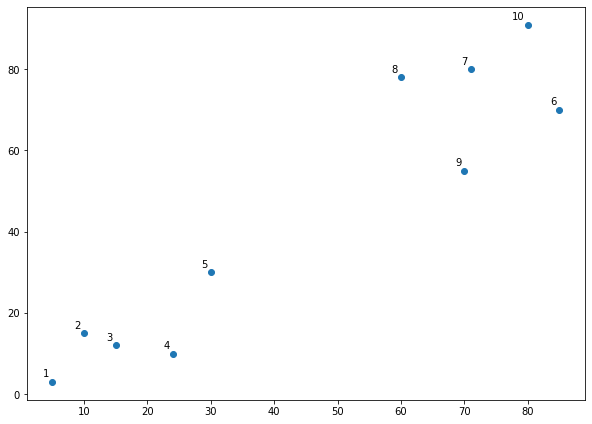

In [15]:
import matplotlib.pyplot as plt

labels = range(1, 11)
plt.figure(figsize=(10, 7))
plt.subplots_adjust(bottom=0.1)
plt.scatter(X[:,0],X[:,1], label='True Position')

for label, x, y in zip(labels, X[:, 0], X[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.draw

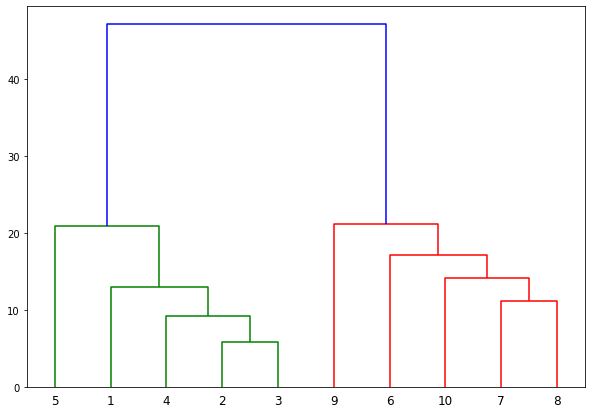

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X, 'single')

labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

Dendrogram pokazuje jak łączyły się klastry. Ponadto "wysokość" linii oznaczającej połączenie oznacza jaką występuje odległość między klastrami. Dla klastrów reprezentowanych przez punkty 2 i 3 (pamiętajmy że pojedyncze punty to też klastry!) odległość jest niewielka, więc klastry te łączą się szybko. Później następuje połączenie między klasterm 2,3 i 4, potem między 7 i 8, potem między 4,2,3 i 1 itp. Na sam koniec łączą się klastry 5,1,4,2,3 i 9,6,10,7,8. Dzięki dendrogramowi możemy znaleźć "moment" w którym mamy określoną ilość klastrów. W ten sposób możemy uzyskać żądany podział na klastry.

### Hierarchical Clustering - przykład

Naszym przykładem będzie podział klientów na grupy na podstawie ich cech.

In [17]:
import pandas as pd

customer_data = pd.read_csv('shopping-data.csv')

In [18]:
customer_data.shape

(200, 5)

In [19]:
customer_data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Zostawmy z tych danych tylko informacje o dochodzie i wydatkach

In [20]:
data = customer_data.iloc[:, 3:5].values

Teraz spotykamy następujący problem: skąd mamy wiedzieć ile jest grup klientów? Z pomocą przychodzi nam dendrogram

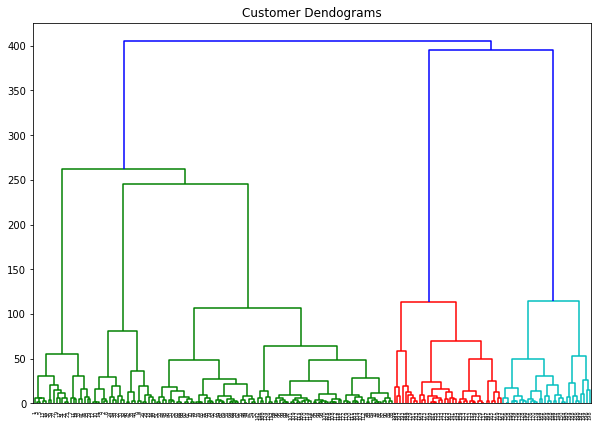

In [21]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

Na podstawie obserwacji dendrogramu decydujemy, że sensowny jest podział na 5 klastrów

In [22]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster.fit_predict(data)

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 2,
       1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2])

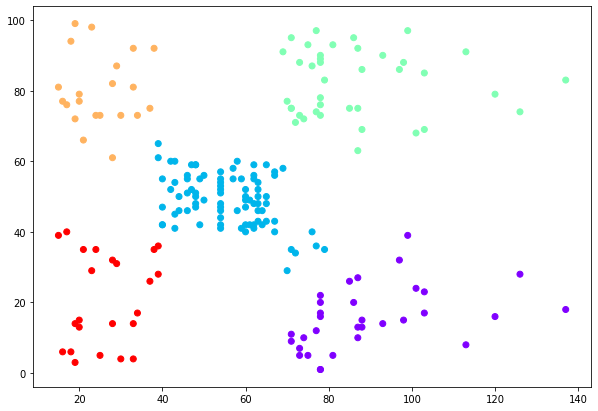

In [23]:
plt.figure(figsize=(10, 7))
plt.scatter(data[:,0], data[:,1], c=cluster.labels_, cmap='rainbow')

Doszło do podziału na 5 grup: lewy dolny róg reprezentuje ludzi o niskich dochodzach i wydatkach. Prawy dolny to wysokie zarobki i niskie wydatki itd. Największa grupa znajduje się w środku i stanowią ją ludzie o średnich dochodzach i wydatkach. Teraz mogąc zaklasyfikować klienta do jednej z grup będzie można np. oferować mu odpowiednie produkty.

## 3a. Zadanie

Dla zbioru z początku tutoriala (zbiór cyfr) wykorzystaj metodę k-means do rozpoznawania cyfr

In [24]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score

def compareWithTarget(clusters, digits_target):
    labels = np.zeros_like(clusters)
    for i in range(10):
        mask = (clusters == i)
        labels[mask] = mode(digits_target[mask])[0]
    print(accuracy_score(digits_target, labels))

In [25]:
def printCentroids(cluster_centers):
    ig, ax = plt.subplots(2, 5, figsize=(8, 3))
    centers = cluster_centers.reshape(10, 8, 8)
    for axi, center in zip(ax.flat, centers):
        axi.set(xticks=[], yticks=[])
        axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

# funkcja pokaże, przy których cyfrach występuje problem z wykryciem przez wytrenowany model
def printConfusionMatrix(target, clusters):
    labels = np.zeros_like(clusters)
    for i in range(10):
        mask = (clusters == i)
        labels[mask] = mode(digits_target[mask])[0]
    mat = confusion_matrix(target, labels)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [27]:
def plot2D(centers, data, original_target, predicted_target, limit=500):
    center_index = np.array([np.where((data == i).all(axis=1))[0] for i in centers]).flatten()
    
    data_2d = PCA(n_components=2).fit_transform(data)
    center_2d = np.array([data_2d[i] for i in center_index])
    
    data_2d = data_2d[:limit,:]
    original_target_reduced = original_target[:limit]
    predicted_target_reduced = predicted_target[:limit]
    
    plt.figure(1)
    plt.title("wlasciwe odwzorowanie")
    plt.scatter(data_2d[:,0], data_2d[:,1], c=original_target_reduced, cmap='viridis')
    plt.figure(2)
    plt.title("klasteryzacja")
    plt.scatter(data_2d[:,0], data_2d[:,1], c=predicted_target_reduced, cmap='viridis')
    plt.scatter(center_2d[:,0], center_2d[:,1], c="red")

In [28]:
def plot3D(centers, data, original_target, predicted_target, limit=500):
    centers_index = np.array([np.where((data == i).all(axis=1))[0] for i in centers]).flatten()
    data_3d = PCA(n_components=3).fit_transform(data) 
    center_3d = np.array([data_3d[i] for i in centers_index])
    
    data_3d = data_3d[:limit,:]
    predicted_target_reduced = predicted_target[:limit]

    #plotowanie
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c=predicted_target_reduced, cmap='viridis')
    ax.scatter(center_3d[:, 0], center_3d[:, 1], center_3d[:, 2], s=300, c='red')

In [29]:
# Wykorzystaj przedstawione wyżej funkcje do sprawdzenia jakości predykcji i narysowaniu narysowaniu centrów klastrów
# Podpowiedź: centroidy klastrów osiąga się przez kmeans.cluster_centers_

data = digits_data
target = digits_target

model = pass #Stwórz klasyfikator z odpowiednią ilością klastrów
predicted_target = pass #wytrenuj model i przprowadź klasyfikację danych
centers = pass #pobierz z modelu próbki centralne w klastrach
printCentroids(pass) #wypisz próbki centralne w klastrach
compareWithTarget(pass) # sprawdź dokładność klasteryzacji

In [30]:
#spróbuj zinterpretować wyniki na diagramie 2D
#liczbę próbek na wykresie można zmienić za pomocą parametru limit
plot2D(pass)

SyntaxError: invalid syntax (<ipython-input-30-f40aedd7f3ea>, line 3)

In [ ]:
#spróbuj zinterpretować wyniki na diagramie 3D
#liczbę próbek na wykresie można zmienić za pomocą parametru limit
plot3D(pass)

In [ ]:
printConfusionMatrix(pass) #wygeneruj mapę ciepła

## 3b. Zadanie

Zrób to samo dla metod PAM i aglomeracyjnego klastrowania hierarchicznego.

Dla PAM sprawdź rezultaty dla zastosowania różnych metryk (np. "manhattan", "cosine", "euclidean").

Zwróć uwagę, że dla aglomeracyjnego klastrowania hierarchicznego funkcja printCentroids nie ma zastosowania, ponieważ przy tej metodzie nie wyznaczamy centroidów. Tutaj wystarczy wypisanie dokładności rozwiązania, oraz skorzystanie z printConfusionMatrix.

Krótko skomentuj otrzymane wyniki: